In [1]:
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, TrainingArguments, Trainer, AutoModelForImageClassification
from datasets import load_dataset, load_metric
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)
import torchvision.models

# Loading Flowers dataset from Hugging Face

In [2]:
data = load_dataset('nelorth/oxford-flowers')
# contains 'train' and 'test' split as downloaded. let's further split 'train' into 'train' and 'val'.
train_ds, test_ds = data["train"], data["test"]
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [3]:
train_ds = train_ds.shuffle(seed=42)
val_ds = val_ds.shuffle(seed=42)
test_ds = test_ds.shuffle(seed=42)

In [26]:
# Each class contains between 40 and 258 images
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 6452
})

In [5]:
# map label indices to labels for interpretability/clarity (I did this by hand/eye :( )
labels = {0: "pink primrose", 1: "globe thistle", 2: "blanket flower", 3: "trumpet creeper",
          4: "blackberry lily", 5: "snapdragon", 6: "colt's foot", 7: "king protea", 
          8: "spear thistle", 9: "yellow iris", 10: "globe-flower",  11: "purple coneflower", 
          12: "peruvian lily", 13: "balloon flower", 14: "hard-leaved pocket orchid", 
          15: "giant white arum lily", 16: "fire lily", 17: "pincushion flower", 18: "fritillary", 
          19: "red ginger", 20: "grape hyacinth", 21: "corn poppy", 22: "prince of wales feathers", 
          23: "stemless gentian", 24: "artichoke", 25: "canterbury bells", 26: "sweet william",
          27: "carnation", 28: "garden phlox", 29: "love in the mist", 30: "mexican aster",
          31: "alpine sea holly", 32: "ruby-lipped cattleya", 33: "cape flower", 34: "giant masterwort", 
          35: "siam tulip", 36: "sweet pea", 37: "lenten rose", 38: "barbeton daisy", 
          39: "daffodil", 40: "sword lily", 41: "poinsettia", 42: "bolero deep blue", 43: "wallflower", 
          44: "marigold", 45: "buttercup", 46: "oxeye daisy", 47: "english marigold", 
          48: "common dandelion", 49: "petunia", 50: "wild pansy", 51: "primula", 52: "sunflower", 
          53: "pelargonium", 54: "bishop of llandaff", 55: "gaura", 56: "geranium", 57: "orange dahlia", 
          58: "tiger lily", 59: "pink-yellow dahlia", 60: "cautleya spicata", 61: "japanese anemone", 
          62: "black-eyed susan", 63: "silverbush", 64: "californian poppy", 65: "osteospermum", 
          66: "spring crocus", 67: "bearded iris", 68: "windflower", 69: "moon orchid",
          70: "tree poppy", 71: "gazania", 72: "azalea", 73: "water lily", 74: "rose", 
          75: "thorn apple", 76: "morning glory", 77: "passion flower", 78: "lotus", 79: "toad lily",
          80: "bird of paradise", 81: "anthurium", 82: "frangipani", 83: "clematis", 84: "hibiscus", 
          85: "columbine", 86: "desert rose", 87: "tree mallow", 88: "magnolia", 89: "cyclamen",
          90: "watercress", 91: "monkshood", 92: "canna lily", 93: "hippeastrum", 94: "bee balm", 
          95: "ball moss", 96: "foxglove", 97: "bougainvillea", 98: "camellia", 99: "mallow", 
          100: "mexican petunia", 101: "bromelia"}
label2id = {label:id for id,label in labels.items()}

globe-flower


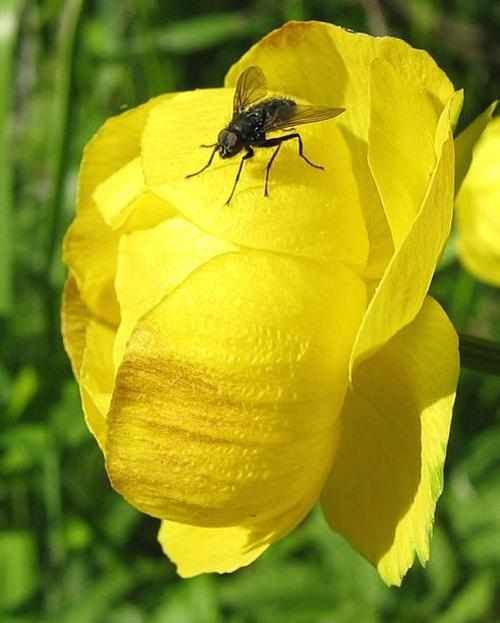

In [30]:
# tinker around with example_num (0 to 6451) to see different flowers and their corresponding labels
example_num = 6451
print(labels[train_ds[example_num]["label"]])
train_ds[example_num]["image"]

# Preprocessing the data

In [8]:
# ResNet50 is trained on ImageNet1k at resolution 224x224.
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["shortest_edge"]

/Users/vishnu/opt/anaconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [9]:
# During training time, we want to make sure the data being fed into our ResNet is of the same 'character' as 
# images it was trained on.

normalize = Normalize(image_mean, image_std)

train_augs = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize])

test_augs = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize])

def train_transforms(examples):
    examples['pixel_values'] = [train_augs(image) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [test_augs(image) for image in examples['image']]
    return examples

# track these pixel values because 
train_ds.set_transform(train_transforms)
val_ds.set_transform(train_transforms)
test_ds.set_transform(test_transforms)

# Load ResNet50 from HuggingFace, modify model head, and train on Flowers

In [11]:
num_labels = len(labels)
model = AutoModelForImageClassification.from_pretrained(
    "microsoft/resnet-50", 
    label2id=label2id,
    id2label=labels,
    ignore_mismatched_sizes = True,
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([102, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
metric_name = "accuracy"
metric = load_metric(metric_name)

args = TrainingArguments(
    f"test-resnet-50",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100,
    remove_unused_columns=False,
    optim="adafactor",
    use_mps_device=True,
)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_data(examples):
    """Batching pixel values and labels together"""
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

/var/folders/26/rd3v1z6n5lnfd6pk9xx3hyrr0000gn/T/ipykernel_61748/677736082.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric(metric_name)
/Users/vishnu/opt/anaconda3/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/Users/vishnu/opt/anaconda3/lib/python3.10/site-packages/transformers/training_args.py:2046: UserWarning: `use_mps_device` is deprecated 

In [13]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    data_collator=collate_data,
)

In [14]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vpamula. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.946900,1.061946,0.744770
2,0.489300,0.315370,0.910739
3,0.267500,0.239277,0.931660


TrainOutput(global_step=1212, training_loss=0.9193995659894282, metrics={'train_runtime': 1969.0838, 'train_samples_per_second': 9.83, 'train_steps_per_second': 0.616, 'total_flos': 4.1461447313793024e+17, 'train_loss': 0.9193995659894282, 'epoch': 3.0})

# Inference

In [15]:
outputs = trainer.predict(test_ds)

In [16]:
print(outputs.metrics)

{'test_loss': 0.14425183832645416, 'test_accuracy': 0.9598039215686275, 'test_runtime': 24.6819, 'test_samples_per_second': 41.326, 'test_steps_per_second': 10.331}


clematis clematis


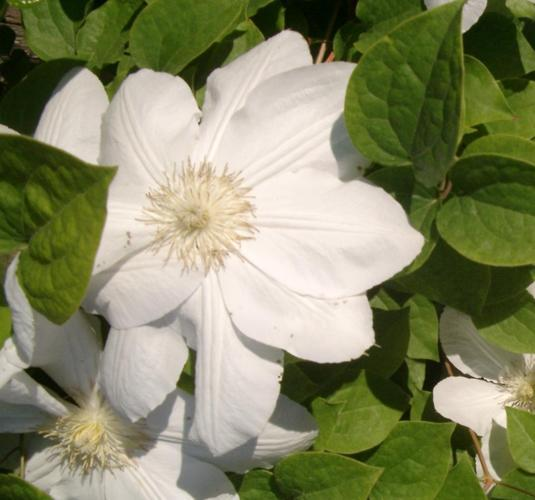

In [25]:
te = 954
# example prediction
# predicted, actual
print(labels[outputs.label_ids[te]], labels[test_ds[te]["label"]])
test_ds[te]["image"]

# Conclusions

This notebook finetunes the ResNet50 model on the Flowers102 dataset from Oxford University, with a final accuracy of ~96% during inference. The best public scores on this dataset are over 99%, making it a good pedagogical exercise to compare with SOTA models. I used Hugging Face to load the dataset and model, and PyTorch and Hugging Face's Trainer API to train it. The main things that can be improved fall into one of two categories: training time and accuracy. To reduce training time, there are several things I could do from running on the cloud (i.e. AWS Sagemaker) with more GPUs to better hyperparameter tuning, trying different optimizers, batch sizes, learning rates; also there are some interesting speed improvements from using mixed precision computation and model compiling (this seems to only be applicable for newer hardware that I don't have). To improve accuracy, I could train for more epochs (there is built-in learning rate decay in Trainer), or add more layers/neurons. One thing that would be interesting to try is to have a low learning rate for all layers except the final layer, and boost the learning rate by 10x-10000x for just the final layer; because this layer is randomly initialized while the rest of the model is already pre-trained, it may benefit from a 'jump-start.'